<a href="https://colab.research.google.com/github/jesusgl86/Deep-Learning-Course/blob/main/M2H3141.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install setuptools==66.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [2]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gym
  Running setup.py clean f

In [3]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

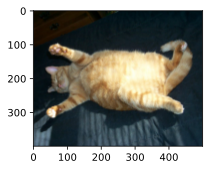

In [4]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [5]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

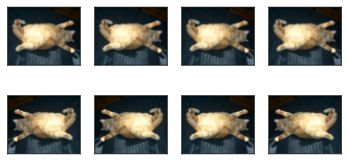

In [6]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

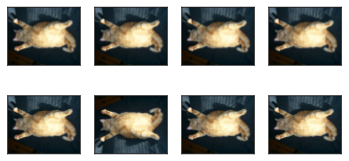

In [7]:
apply(img, torchvision.transforms.RandomVerticalFlip())

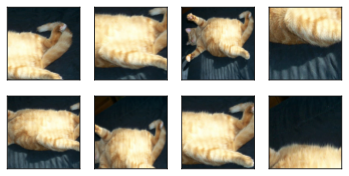

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

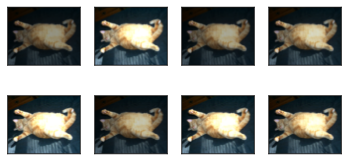

In [9]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

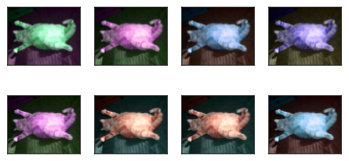

In [10]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

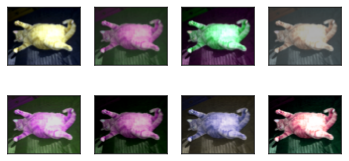

In [11]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

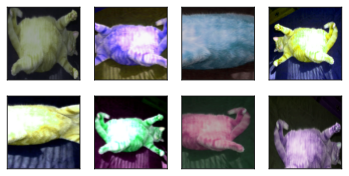

In [12]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


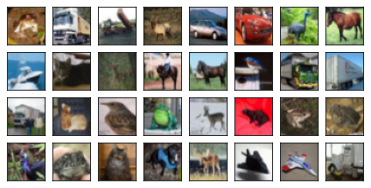

In [13]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [14]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [15]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [16]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [17]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.215, train acc 0.925, test acc 0.836
1160.8 examples/sec on [device(type='cuda', index=0)]


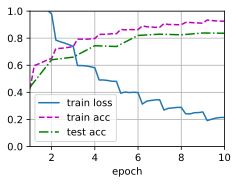

In [18]:
train_with_data_aug(train_augs, test_augs, net)

loss 0.090, train acc 0.968, test acc 0.808
1179.4 examples/sec on [device(type='cuda', index=0)]


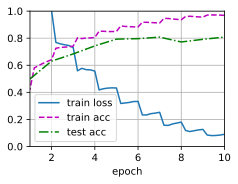

In [22]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

train_with_data_aug(test_augs, test_augs, net)